In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

## Data Preprocessing

In [2]:
ret_df = pd.read_feather('data/nasdaq_etfs.feather') # contains daily percentage returns (NOTE: 0.747 means 0.747% not 74.7%)

symmap = pd.read_csv("data/symbol2name.csv")
sym2name = dict(zip(symmap["Symbol"], symmap["Security Name"]))
syms2drop = []
for sym in ret_df.columns:
    name = sym2name.get(sym, None)
    if name is None: continue
    if re.search(r"\b(bill)\b", name.lower()):
        # print(sym, "|", name)
        syms2drop.append(sym)
ret_df.drop(columns=syms2drop, inplace=True)

ret_df.head()

Ticker          AAXJ      ACWI      ACWX       AFK       AGQ       AIA  \
Date                                                                     
2010-07-13  0.747621  1.562114  1.686754  1.853138  2.700842  0.854489   
2010-07-14 -0.380087  0.372102  0.263322  0.034330  1.457285  0.051332   
2010-07-15 -0.763130  0.098904  0.157541  0.274559 -0.511807 -0.821128   
2010-07-16 -2.453279 -2.765485 -2.884077 -1.540060 -4.829074 -2.664938   
2010-07-19  1.144909  0.634864  0.539948 -0.451860 -2.580644  1.302489   

Ticker          AIVI      AIVL       AOA       AOK  ...       XRT       XSD  \
Date                                                ...                       
2010-07-13  1.788925  1.268345  1.884208  0.435343  ...  2.734448  2.155864   
2010-07-14  0.051002 -0.168632 -0.470754  0.000000  ... -0.452477  0.065970   
2010-07-15  1.603865  0.192969 -0.135120  0.108410  ...  0.588216 -0.131862   
2010-07-16 -2.706147 -2.167090 -2.063619 -0.721728  ... -3.561905 -2.947607   
2010-07-19  0.566597  1.058404  0.207255  0.072730  ...  0.385863  2.606528   

Ticker          XSMO      XSVM      YANG       YCL       YCS      YINN  \
Date                                                                     
2010-07-13  3.351985  3.351523 -2.632439  0.140403 -0.369203  2.300923   
2010-07-14  0.154452 -0.603311  2.571722  0.385555 -0.476437 -2.663477   
2010-07-15 -0.462618  0.379324  2.828656  1.815644 -1.968086 -2.827608   
2010-07-16 -3.718039 -3.930446  5.470490  2.023320 -1.627784 -5.882389   
2010-07-19  0.402229  0.393409 -2.874933 -0.336136  0.386099  3.158260   

Ticker           YXI       ZSL  
Date                            
2010-07-13 -0.936347 -2.774568  
2010-07-14  1.155257 -1.634958  
2010-07-15  0.000000  0.302206  
2010-07-16  3.612906  5.122025  
2010-07-19 -0.420834  2.694180  

[5 rows x 546 columns]

In [3]:
growth = 1 + ret_df/100
price_df = growth.cumprod().shift(1, fill_value=1)
price_df.head()

Ticker          AAXJ      ACWI      ACWX       AFK       AGQ       AIA  \
Date                                                                     
2010-07-13  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2010-07-14  1.007476  1.015621  1.016868  1.018531  1.027008  1.008545   
2010-07-15  1.003647  1.019400  1.019545  1.018881  1.041975  1.009063   
2010-07-16  0.995988  1.020409  1.021151  1.021678  1.036642  1.000777   
2010-07-19  0.971553  0.992189  0.991701  1.005944  0.986582  0.974107   

Ticker          AIVI      AIVL       AOA       AOK  ...       XRT       XSD  \
Date                                                ...                       
2010-07-13  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
2010-07-14  1.017889  1.012683  1.018842  1.004353  ...  1.027344  1.021559   
2010-07-15  1.018408  1.010976  1.014046  1.004353  ...  1.022696  1.022233   
2010-07-16  1.034742  1.012927  1.012676  1.005442  ...  1.028712  1.020885   
2010-07-19  1.006741  0.990976  0.991778  0.998186  ...  0.992070  0.990793   

Ticker          XSMO      XSVM      YANG       YCL       YCS      YINN  \
Date                                                                     
2010-07-13  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2010-07-14  1.033520  1.033515  0.973676  1.001404  0.996308  1.023009   
2010-07-15  1.035116  1.027280  0.998716  1.005265  0.991561  0.995762   
2010-07-16  1.030328  1.031177  1.026966  1.023517  0.972046  0.967605   
2010-07-19  0.992020  0.990647  1.083146  1.044226  0.956224  0.910687   

Ticker           YXI       ZSL  
Date                            
2010-07-13  1.000000  1.000000  
2010-07-14  0.990637  0.972254  
2010-07-15  1.002081  0.956358  
2010-07-16  1.002081  0.959249  
2010-07-19  1.038285  1.008381  

[5 rows x 546 columns]

In [4]:
log_price_df = np.log(price_df)
log_price_df.head()

Ticker          AAXJ      ACWI      ACWX       AFK       AGQ       AIA  \
Date                                                                     
2010-07-13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2010-07-14  0.007448  0.015500  0.016727  0.018362  0.026650  0.008509   
2010-07-15  0.003640  0.019215  0.019357  0.018705  0.041118  0.009022   
2010-07-16 -0.004020  0.020203  0.020931  0.021447  0.035987  0.000777   
2010-07-19 -0.028859 -0.007841 -0.008334  0.005926 -0.013509 -0.026234   

Ticker          AIVI      AIVL       AOA       AOK  ...       XRT       XSD  \
Date                                                ...                       
2010-07-13  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2010-07-14  0.017731  0.012604  0.018667  0.004344  ...  0.026977  0.021330   
2010-07-15  0.018241  0.010916  0.013948  0.004344  ...  0.022442  0.021989   
2010-07-16  0.034152  0.012844  0.012596  0.005427  ...  0.028307  0.020670   
2010-07-19  0.006718 -0.009065 -0.008256 -0.001816  ... -0.007962 -0.009250   

Ticker          XSMO      XSVM      YANG       YCL       YCS      YINN  \
Date                                                                     
2010-07-13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2010-07-14  0.032970  0.032966 -0.026677  0.001403 -0.003699  0.022749   
2010-07-15  0.034514  0.026914 -0.001285  0.005251 -0.008475 -0.004247   
2010-07-16  0.029877  0.030701  0.026609  0.023245 -0.028352 -0.032931   
2010-07-19 -0.008012 -0.009397  0.079870  0.043276 -0.044764 -0.093556   

Ticker           YXI       ZSL  
Date                            
2010-07-13  0.000000  0.000000  
2010-07-14 -0.009408 -0.028138  
2010-07-15  0.002079 -0.044623  
2010-07-16  0.002079 -0.041605  
2010-07-19  0.037570  0.008347  

[5 rows x 546 columns]

In [5]:
# We use first 40% of data for cointegration test
train_size = int(len(log_price_df) * 0.40)

price_df_train = price_df.iloc[:train_size]
log_price_df_train = log_price_df.iloc[:train_size]
ret_df_train = ret_df.iloc[:train_size-1]

## Initial Analysis on Pairs

In [6]:
pairs_df = pd.read_csv('data/pairs_df.csv', index_col=0)
pairs_df

y-sym x-sym                                       y-name  \
0       DBP   XLF              Invesco DB Precious Metals Fund   
1       FXF   KRE     Invesco CurrencyShares Swiss Franc Trust   
2       CEF   DXJ  Sprott Physical Gold and Silver Trust Units   
3       FXF   RFG     Invesco CurrencyShares Swiss Franc Trust   
4       FXF   SCC     Invesco CurrencyShares Swiss Franc Trust   
...     ...   ...                                          ...   
11947   IYY   VTI                   iShares Dow Jones U.S. ETF   
11948   AGQ  SIVR                       ProShares Ultra Silver   
11949  SIVR   SLV             abrdn Physical Silver Shares ETF   
11950   AGQ   SLV                       ProShares Ultra Silver   
11951   GLD  SGOL                             SPDR Gold Shares   

                                              x-name  coint-pvalue  \
0      State Street Financial Select Sector SPDR ETF      0.012016   
1         State Street SPDR S&P Regional Banking ETF      0.030970   
2                WisdomTree Japan Hedged Equity Fund      0.002647   
3             Invesco S&P MidCap 400 Pure Growth ETF      0.044758   
4        ProShares UltraShort Consumer Discretionary      0.018839   
...                                              ...           ...   
11947                Vanguard Total Stock Market ETF      0.041366   
11948               abrdn Physical Silver Shares ETF      0.008840   
11949                           iShares Silver Trust      0.033142   
11950                           iShares Silver Trust      0.008262   
11951                 abrdn Physical Gold Shares ETF      0.000178   

           lev-stat  intercept       lev       cor  px_error_cor  \
0        -66.975476   0.321275 -0.696400  0.000010      0.501470   
1        -13.021511   0.135804 -0.067784  0.000020      0.948085   
2        -84.954622   0.291072 -0.977648  0.000021      0.415615   
3         -6.844593   0.136215 -0.042779  0.000026      0.984810   
4         13.966198   0.148834  0.023309  0.000049      0.940957   
...             ...        ...       ...       ...           ...   
11947   5871.460423  -0.000213  0.986418  0.996236      0.006612   
11948    158.005829  -0.741661  2.576331  0.996814      0.238592   
11949   5706.578077   0.008462  0.991104  0.997515      0.006803   
11950    161.826531  -0.720639  2.556870  0.998252      0.233269   
11951  15010.989651  -0.000211  1.000906  0.998903      0.002586   

       ret_error_cor  station-stat  station-pvalue      svm1       svm2  
0           0.808737     -1.257735        0.648280 -0.571824  -1.283669  
1           0.991467     -3.142417        0.023569 -0.656201  -1.723573  
2           0.767507     -1.223104        0.663579 -0.373101  -1.127769  
3           0.997802     -3.142417        0.023569 -0.606316  -1.735874  
4           0.998247     -3.142417        0.023569 -0.664138  -1.736687  
...              ...           ...             ...       ...        ...  
11947       0.077269     -1.489897        0.538503  4.960013  12.863050  
11948      -0.959618     -1.254705        0.649632  1.213632   0.704931  
11949       0.180863     -1.254705        0.649632  4.935318   9.636629  
11950      -0.972893     -1.231729        0.659800  1.308742   0.682489  
11951       0.095007     -1.538321        0.514477  5.004605  12.270279  

[11952 rows x 15 columns]

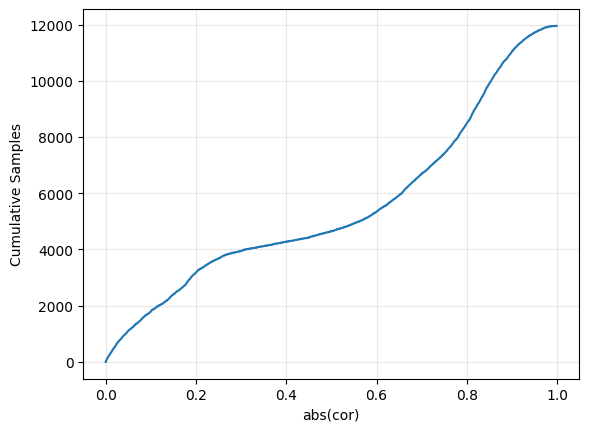

In [14]:
xs = np.sort(np.abs(pairs_df['cor']))
ys = np.arange(1, xs.size + 1)

plt.figure()
plt.step(xs, ys, where="post")
plt.xlabel("abs(cor)")
plt.ylabel("Cumulative Samples")
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
opt = 'log-px'
pair = pairs_df.iloc[4342]

sym_y, sym_x = pair[['y-sym', 'x-sym']]
if opt=='log-px':
    df_ = log_price_df_train
    y = df_[sym_x]*pair['lev']
else:
    df_ = price_df_train
    y = df_[sym_x]
print(pair)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_.index, y=df_[sym_y], name=sym_y))
fig.add_trace(go.Scatter(x=df_.index, y=y, name=sym_x))
if opt=='log-px':
    error = df_[sym_y]-df_[sym_x]*pair['lev']
    fig.add_trace(go.Scatter(
        x=df_.index, y=error, name='error', 
        line = dict(color='black', width=1),
    ))
fig.show()

y-sym                                                EWK
x-sym                                                LTL
y-name                          iShares MSCI Belgium ETF
x-name            ProShares Ultra Communication Services
coint-pvalue                                    0.020028
lev-stat                                      129.851448
intercept                                      -0.106562
lev                                             0.674226
cor                                             0.421975
px_error_cor                                    0.286432
ret_error_cor                                  -0.614716
station-stat                                   -1.389822
station-pvalue                                  0.587146
svm1                                            0.282628
svm2                                            0.795722
Name: 4342, dtype: object


Notes
- Useful features: cor, px_error_cor, ret_error_cor
- Stationarity of log-prices don't really correlate with mismatch

To do
- Remove those where sign(lev)!=sign(cor)

## Feature Selection

In [70]:
X = pairs_df[['cor','px_error_cor','ret_error_cor', 'lev-stat','intercept','station-stat']].abs()
y = (np.sign(pairs_df['lev'])==np.sign(pairs_df['cor'])).astype('category')

In [72]:
multi_idx = pd.MultiIndex.from_product([
    ['roc-auc', 'cor', 'logit-l1', 'logit-enet', 'logit-l2', 'vif', 'knn-mi'],
    ['feature', 'value'],
])
feature_metrics = pd.DataFrame(columns=multi_idx)

# roc-auc
li = np.array([roc_auc_score(y, X[col]) for col in X.columns])
li = np.maximum(li, 1-li)
li = sorted(zip(X.columns, li), key=lambda x: -x[1])
feature_metrics.loc[:, 'roc-auc'] = li

# cor
li = sorted([[
    col, np.corrcoef(X[col], y.astype('float'))[0,1]
]for col in X.columns], key=lambda x: -abs(x[1]))
feature_metrics.loc[:, 'cor'] = li

# logit-l1
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        penalty="l1", solver="saga",
        scoring="roc_auc", # or "accuracy", "f1", "neg_log_loss",
        cv=10, Cs=10, refit=True, random_state=0,
        max_iter=5000, n_jobs=-1, 
    ))
])
model.fit(X, y)
coef = model.named_steps['clf'].coef_.ravel()
li = sorted(zip(X.columns, coef), key=lambda x: -abs(x[1]))
feature_metrics.loc[:, 'logit-l1'] = li

# logit-enet
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        penalty="elasticnet", solver="saga", l1_ratios=[0.5],
        scoring="roc_auc", # or "accuracy", "f1", "neg_log_loss",
        cv=10, Cs=10, refit=True, random_state=0,
        max_iter=5000, n_jobs=-1,
    ))
])
model.fit(X, y)
coef = model.named_steps["clf"].coef_.ravel()
li = sorted(zip(X.columns, coef), key=lambda x: -abs(x[1]))
feature_metrics.loc[:, 'logit-enet'] = li

# logit-l2
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        penalty="l2",
        scoring="roc_auc", # or "accuracy", "f1", "neg_log_loss",
        cv=10, random_state=0,
        max_iter=5000, n_jobs=-1,
    ))
])
model.fit(X, y)
coef = model.named_steps["clf"].coef_.ravel()
li = sorted(zip(X.columns, coef), key=lambda x: -abs(x[1]))
feature_metrics.loc[:, 'logit-l2'] = li

# vif
li = sorted([[
    col, variance_inflation_factor(X.values, i)
]for i, col in enumerate(X.columns)], key=lambda x: x[1])
feature_metrics.loc[:, 'vif'] = li

# knn-mi
li = mutual_info_classif(
    X.to_numpy(), y.to_numpy(), 
    discrete_features='auto', random_state=0
)
li = sorted(zip(X.columns, li), key=lambda x: -x[1])
feature_metrics.loc[:, 'knn-mi'] = li

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [73]:
feature_metrics

roc-auc                      cor                 logit-l1            \
         feature     value        feature     value        feature     value   
0            cor  0.912764            cor  0.717553            cor  0.992487   
1      intercept  0.905493      intercept -0.583503      intercept -0.277553   
2       lev-stat  0.830777   px_error_cor -0.507499   px_error_cor       0.0   
3   px_error_cor  0.830777  ret_error_cor -0.366434  ret_error_cor       0.0   
4  ret_error_cor  0.710185       lev-stat   0.28229       lev-stat       0.0   
5   station-stat  0.628561   station-stat  0.191967   station-stat       0.0   

      logit-enet                 logit-l2                      vif             \
         feature     value        feature     value        feature      value   
0            cor  0.775908            cor  0.256122       lev-stat   1.777108   
1      intercept -0.466412      intercept -0.203861      intercept   2.366645   
2   px_error_cor -0.324488   px_error_cor -0.168806            cor  10.391803   
3   station-stat  0.137962  ret_error_cor -0.111179  ret_error_cor   18.51367   
4  ret_error_cor -0.036655   station-stat  0.099994   px_error_cor  22.148245   
5       lev-stat       0.0       lev-stat  0.083933   station-stat  26.155214   

          knn-mi            
         feature     value  
0            cor  0.348278  
1      intercept  0.293036  
2       lev-stat  0.253436  
3   px_error_cor   0.25343  
4  ret_error_cor  0.166239  
5   station-stat  0.096094

In [300]:
def plot_roc(X, y):
    yv = np.asarray(y).ravel()
    auc_li = np.array([roc_auc_score(y, X[col]) for col in X.columns])
    swap = auc_li < 0.5
    auc_li[swap] = 1 - auc_li[swap]
    auc_li = sorted(zip(X.columns, auc_li, swap), key=lambda x: -x[1])

    for name, auc, swap in auc_li:
        xv = X[name].astype(float)
        if swap: xv = -xv
        fpr, tpr, _ = roc_curve(yv, xv)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], linewidth=1) # Diagonal baseline
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

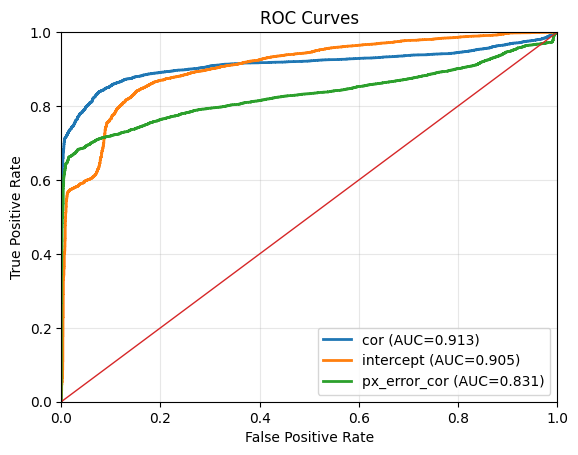

In [ ]:
plot_roc(X, y)

In [215]:
np.corrcoef([
    np.sqrt(1/np.power(X['px_error_cor'], 2) - 1), 
    X['lev-stat']
])[0,1]

1.0

- cor is best so far, clearly separates
- intercept is interestingly significant
- ret_error_cor & px_error_cor might have multicollinearity
- should exclude station-stat
- lev-stat is proportional to 1/sqrt(px_error_cor^2 - 1)

In [12]:
fig = go.Figure()
good = (np.sign(pairs_df['lev'])==np.sign(pairs_df['cor']))
hovertemplate = (
    "%{customdata[1]}<br>"
    "%{customdata[2]}<br>"
    "<b>%{customdata[0]}</b>"
)

featx = 'cor'
featy = 'ret_error_cor'
pairs_df_good = pairs_df[good]
fig.add_trace(go.Scatter(
    x=pairs_df_good[featx].abs(), y=pairs_df_good[featy].abs(),
    mode='markers', marker=dict(opacity=0.3), name='good',
    # hovertemplate=hovertemplate, customdata=np.column_stack([
    #     pairs_df_good.index.to_numpy(),
    #     pairs_df_good[['y-name','x-name']].to_numpy(),
    # ])
))
pairs_df_bad = pairs_df[~good]
fig.add_trace(go.Scatter(
    x=pairs_df_bad[featx].abs(), y=pairs_df_bad[featy].abs(),
    mode='markers', marker=dict(opacity=0.3), name='bad',
    # hovertemplate=hovertemplate, customdata=np.column_stack([
    #     pairs_df_bad.index.to_numpy(),
    #     pairs_df_bad[['y-name','x-name']].to_numpy(),
    # ])
))

x = np.linspace(0, 0.9, 500)
y = 0.31*x + 0.7
fig.add_trace(go.Scatter(x=x, y=y, mode="lines",line=dict(color='black', width=1), name="split"))

fig.update_layout(
    width=700,height=700, xaxis_title=f'abs({featx})', yaxis_title=f'abs({featy})',
)
fig.show()

Interesting pattern with cor and ret_error_cor

In [56]:
# fig = go.Figure()
# good = (np.sign(pairs_df['lev'])==np.sign(pairs_df['cor'])) #& (pairs_df['station-pvalue'] >= 0.05)
# hovertemplate = (
#     "%{customdata[1]}<br>"
#     "%{customdata[2]}<br>"
#     "<b>%{customdata[0]}</b>"
# )
# pairs_df_good = pairs_df[good]

# feat1, feat2, feat3 = 'cor', 'px_error_cor', 'intercept'

# fig.add_trace(go.Scatter3d(
#     x=pairs_df_good[feat1].abs(), y=pairs_df_good[feat2].abs(), z=pairs_df_good[feat3].abs(),
#     mode='markers', marker=dict(opacity=0.3), name='good',
#     # hovertemplate=hovertemplate, customdata=np.column_stack([
#     #     pairs_df_good.index.to_numpy(),
#     #     pairs_df_good[['y-name','x-name']].to_numpy(),
#     # ])
# ))
# pairs_df_bad = pairs_df[~good]
# fig.add_trace(go.Scatter3d(
#     x=pairs_df_bad[feat1].abs(), y=pairs_df_bad[feat2].abs(), z=pairs_df_bad[feat3].abs(),
#     mode='markers', marker=dict(opacity=0.3), name='bad',
#     # hovertemplate=hovertemplate, customdata=np.column_stack([
#     #     pairs_df_bad.index.to_numpy(),
#     #     pairs_df_bad[['y-name','x-name']].to_numpy(),
#     # ])
# ))
# fig.update_layout(
#     width=700,height=700, 
#     scene=dict(
#         xaxis=dict(title=dict(text=f"abs({feat1})")),
#         yaxis=dict(title=dict(text=f"abs({feat2})")),
#         zaxis=dict(title=dict(text=f"abs({feat3})")),
#     ),
# )
# fig.show()

In [150]:
X_ = pairs_df[['cor', 'px_error_cor', 'intercept', 'ret_error_cor']].abs()
vif = pd.Series([
    variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])
], index=X_.columns).sort_values()
print(vif)

intercept         2.273791
cor               4.160771
px_error_cor      9.686423
ret_error_cor    18.417874
dtype: float64


## SVM

Remaining features: cor, px_error_cor, intercept, ret_error_cor
- quadratic
- cor, px_error_cor, intercept

We'll run SVM and compare results wih cor vs ret_error_cor

In [28]:
X = pairs_df[['cor', 'px_error_cor', 'intercept']].abs()
y = np.sign(pairs_df['lev'])==np.sign(pairs_df['cor']).astype('category')

In [32]:
def build_svm(y, X=None, features=None, degree=2, class_weight=None):
    if X is None:
        assert features is not None
        X = pairs_df[features].abs()
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LinearSVC(dual=False, max_iter=20000, class_weight=class_weight))
    ])
    param_grid = {
        "clf__C": np.logspace(-4, 4, 17)
    }
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    gs = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    svm = gs.best_estimator_
    score = svm.decision_function(X)
    return score

def plot_svm(score, featx='cor', featy='ret_error_cor', hover=False):
    fig = go.Figure()

    for status, condition, color in [
        (-2, score<-1, 'rgb(153,0,0)'),
        (-1, (-1<=score)&(score<=0), 'rgb(255,102,102)'),
        (1, (0<=score)&(score<=1), 'rgb(102,102,255)'),
        (2, 1<score, 'rgb(0,0,153)'),
    ]:
        df_ = pairs_df[condition]
        fig.add_trace(go.Scatter(
            x=df_[featx].abs(), y=df_[featy].abs(),
            mode='markers', marker=dict(opacity=0.3, color=color), name=status,
            hovertemplate=(
                "%{customdata[1]}<br>"
                "%{customdata[2]}<br>"
                "score: %{customdata[3]:.3f}<br>"
                "<b>%{customdata[0]}</b>"
            ) if hover else None, customdata=np.column_stack([
                df_.index.to_numpy(),
                df_[['y-name','x-name']].to_numpy(),
                score[condition],
            ]) if hover else None,
        ))

    if featx=='cor' and featy=='ret_error_cor':
        x = np.linspace(0, 0.9, 500)
        y = 0.31*x + 0.7
        fig.add_trace(go.Scatter(x=x, y=y, mode="lines",line=dict(color='black', width=1), name="split"))

    fig.update_layout(
        width=700,height=700, xaxis_title=f'abs({featx})', yaxis_title=f'abs({featy})',
    )
    fig.show()

In [29]:
svm_results = {}
svm_results["svm1"] = build_svm(y, X, degree=2, class_weight={False: 4, True: 1})
X_ = pairs_df[['cor']].abs()
X_['*'] = np.power(pairs_df['ret_error_cor'].abs(), 2)
X_['**'] = np.exp(pairs_df['ret_error_cor'].abs())
svm_results["svm2"] = build_svm(y, X=X_, degree=1, class_weight={False: 8, True: 1})

In [ ]:
plot_svm(svm_results["svm1"], hover=True) # Should try score >= 1.1

In [ ]:
plot_svm(svm_results["svm2"], hover=True) # Should try score >= 0.3

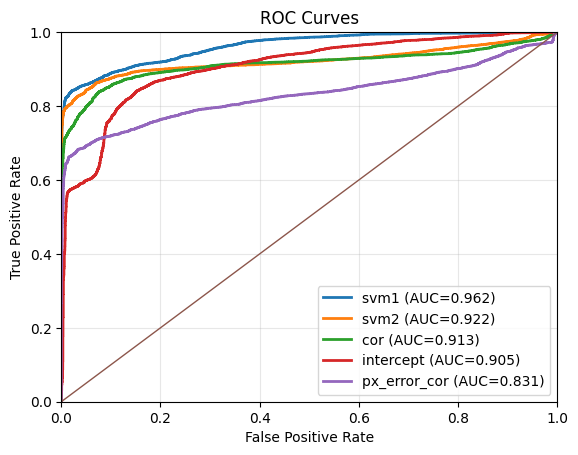

In [483]:
scores_df = pd.DataFrame()
for name, score in svm_results.items():
    scores_df[name] = score
plot_roc(pd.concat([X, scores_df], axis=1), y)

In [484]:
for name, score in svm_results.items():
    pairs_df[name] = score

In [486]:
pairs_df.to_csv('data/pairs_df.csv')